In [1]:
import os
import PIL
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import cv2

from detection.utils.bbox import format_yolov5
from detection.utils.image import drawBox

import yaml
from yaml.loader import SafeLoader

from detection.utils import bbox
from detection.utils import image

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import random

In [2]:
data = yaml.load(open("detection/dataset/data_whole.yaml"), Loader=SafeLoader)
img = cv2.imread("machine_detection2-1/train/IMG_0990_JPG.rf.a807c4a925a70c2efa0ba10ac8f84b27.jpg")
targets = np.genfromtxt("machine_detection2-1/train/labels/IMG_0990_JPG.rf.a807c4a925a70c2efa0ba10ac8f84b27.txt", delimiter=" ")
targets = format_yolov5(targets, img)

# img, targets = aug.crop(img, targets, 0.7)

img_anno = drawBox(img, targets, data["names"])
cv2.imwrite("results/IMG_0990_anno.JPG", img_anno)

True

In [3]:
data = yaml.load(open("detection/dataset/data_whole.yaml"), Loader=SafeLoader)
img = cv2.imread("detection/dataset/machine/images/IMG_0990.JPG")
targets = np.genfromtxt("detection/dataset/machine/whole/labels/IMG_0990.txt", delimiter=" ")
targets = format_yolov5(targets, img)

# img, targets = aug.crop(img, targets, 0.7)

img_anno = drawBox(img, targets, data["names"])
cv2.imwrite("results/IMG_0990_anno.JPG", img_anno)

True

# 2. Preprocessing

## 2.1 Import labels

In [4]:
from detection.utils.dataset import readLabel_yolo
import yaml

data = yaml.load(open("detection/dataset/data_whole.yaml"), Loader=yaml.SafeLoader)
class_names = data["names"]
df_label = readLabel_yolo(label_dir="detection/dataset/machine/whole/labels", class_names=class_names)
df_label.sample(5)

,filename,x,y,w,h,cat
307,IMG_0322,0.221094,0.659375,0.442188,0.681250,6
1039,IMG_0630,0.510156,0.500000,0.570312,1.000000,4
21,IMG_0206,0.728125,0.596094,0.232813,0.532813,6
355,IMG_0345,0.671875,0.542188,0.164844,0.297656,6
951,IMG_0588,0.690625,0.465625,0.185938,0.361719,6


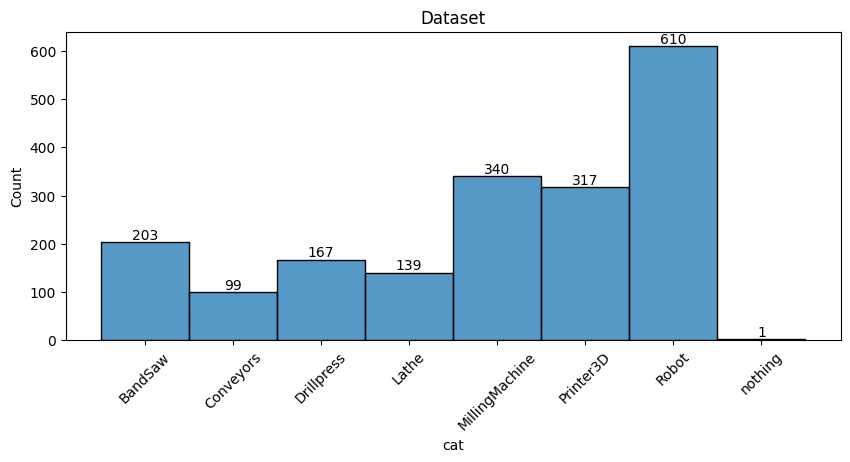

In [5]:
from detection.utils.plot import plothist
import matplotlib.pyplot as plt

fig, axe = plt.subplots(figsize=(10, 4))
plothist(axe, df_label["cat"], class_names + ["nothing"], title="Dataset")
plt.show()

## 2.2 Generate each class using augmentation 

In [6]:
from detection.utils.dataset import Dataset

qwe = Dataset(
    data_path="detection/dataset/data_whole.yaml",
    image_dir="detection/dataset/machine/images",
    label_dir="detection/dataset/machine/whole/labels",
    saved_dir="detection/dataset/machine_preprocessed/whole",)

In [7]:
# qwe.copy_org(resize=(640, 640))

In [10]:
qwe.balance_class(limit=700)

  0%|          | 11/4510 [00:06<48:10,  1.56it/s]

KeyboardInterrupt: 

In [6]:
from detection.utils.dataset import balance_img

balance_img(df_label, limit=700)


IMG_0468
IMG_0734
IMG_0803
IMG_1051
IMG_0697
IMG_0549
IMG_0270
IMG_0377
IMG_0278
IMG_0649


KeyboardInterrupt: 

In [ ]:
df_label = readLabel_yolo(label_dir="detection/dataset/machine_preprocessed/whole/labels", class_names=class_names)
df_label.sample(5)

In [ ]:
from detection.utils.plot import plothist

data = yaml.load(open("detection/dataset/data_whole.yaml"), Loader=SafeLoader)
cat_names = data["names"] + ["nothing"]
fig, axe = plt.subplots(figsize=(10, 4))
plothist(axe, df_label["cat"], cat_names, title="Dataset")
plt.show()

In [219]:
df = df_label
image_dir=f"detection/dataset/machine/images"
saved_dir="detection/dataset/machine_preprocessed/whole"
print(len(df["filename"].unique()))
data = yaml.load(open("detection/dataset/data_whole.yaml"), Loader=SafeLoader)
cat_names = data["names"] + ["Nothing"]


img_aug = [
    A.Resize(height=640, width=640, p=1),
    ]
bbox_aug = A.BboxParams(format='yolo', min_area=1024, min_visibility=0.1)


for file in df["filename"].unique()[:10]:
    arr_labels = df.to_numpy()
    filename = file
    arr_labels = arr_labels[np.where(arr_labels[:,0] == filename)]
    img = np.array(PImage.open(Path(image_dir).joinpath(f"{file}.jpg")))
    
    bboxes = arr_labels[:,1:]
    aug = augment(img, bboxes, cat_names, img_aug, bbox_aug)
    aug.process()
    aug.saved(saved_dir=saved_dir, filename_org=filename)
    print(img)
    


873
[[[  6   6   4]
  [  6   6   4]
  [  7   7   5]
  ...
  [210 210 210]
  [210 210 210]
  [209 209 209]]

 [[  8   7   5]
  [  8   7   5]
  [  8   6   7]
  ...
  [210 210 210]
  [210 210 210]
  [209 209 209]]

 [[  8   6   7]
  [  8   6   7]
  [  9   7   8]
  ...
  [211 211 211]
  [210 210 210]
  [210 210 210]]

 ...

 [[ 71  70  68]
  [ 68  67  65]
  [ 65  63  64]
  ...
  [ 22  22  22]
  [ 23  23  23]
  [ 22  22  22]]

 [[ 68  68  68]
  [ 68  68  68]
  [ 67  67  67]
  ...
  [ 23  23  23]
  [ 22  22  22]
  [ 22  22  22]]

 [[ 64  66  65]
  [ 67  69  68]
  [ 69  71  70]
  ...
  [ 24  24  24]
  [ 23  23  23]
  [ 22  22  22]]]
[[[188 188 188]
  [188 188 188]
  [186 188 185]
  ...
  [203 207 208]
  [204 208 211]
  [205 209 212]]

 [[187 187 187]
  [188 188 188]
  [186 188 185]
  ...
  [204 208 209]
  [204 208 209]
  [204 208 209]]

 [[187 187 185]
  [188 188 186]
  [187 189 186]
  ...
  [206 210 211]
  [206 210 211]
  [206 210 211]]

 ...

 [[115  91  89]
  [121  97  95]
  [125 104  99]


## 2.3 Split dataset

In [238]:
def copyCats(df, cat_id, copies=1):
    df_nothing = df[df["cat"]==cat_id]
    df_list = [df_nothing for i in range(copies)]
    df_list.append(df)
    df = pd.concat(df_list, ignore_index=True)
    return df

df_temp = copyCats(df_label, 7, 5)

X = df_temp.drop("cat", axis=1)
y = df_temp["cat"]

test_size = 0.1
val_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=42, stratify=y, )
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42, stratify=y_train)


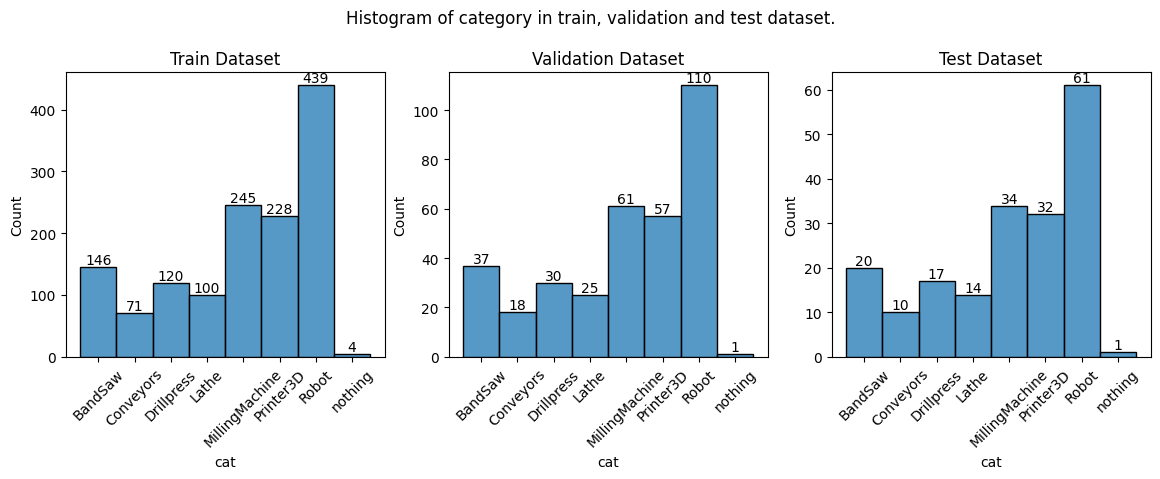

In [239]:
data = yaml.load(open("detection/dataset/data_whole.yaml"), Loader=SafeLoader)
cat_names = data["names"] + ["nothing"]
fig, axe = plt.subplots(1, 3, figsize=(14, 3.7))
fig.suptitle("Histogram of category in train, validation and test dataset.", y=1.05)
plothist(axe[0], y_train, cat_names, title="Train Dataset")
plothist(axe[1], y_val, cat_names, title="Validation Dataset")
plothist(axe[2], y_test, cat_names, title="Test Dataset")
plt.show()


In [137]:
transformed["bboxes"]

[(0.46328125, 0.43671875, 0.20624999999999993, 0.31640625000000006, 5.0),
 (0.35234375, 0.50390625, 0.13203125, 0.29218750000000004, 6.0),
 (0.28671875, 0.021875, 0.09843750000000001, 0.04296875000000001, 5.0)]

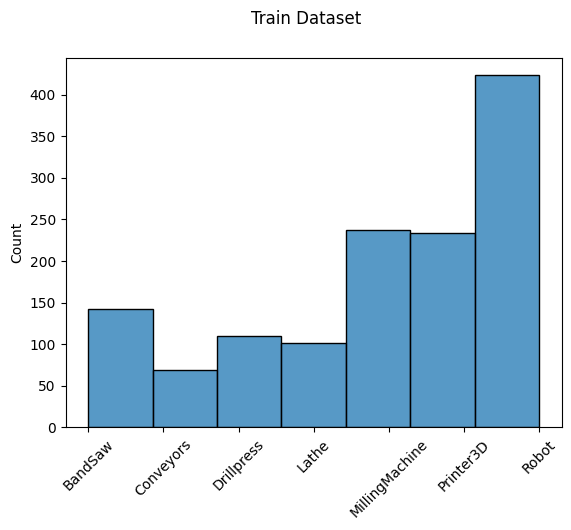

In [8]:
path = "machine_detection2-1/train/labels/"

a_list = []
a_list2 = {}
for filepath in Path(path).iterdir():
    a_arr = np.genfromtxt(filepath, delimiter=" ")
    if len(a_arr.shape) == 1:
        a_arr = a_arr.reshape(1,-1)
    a_list2[filepath.stem] = a_arr[:,0]
    for item in a_arr[:,0]:
        a_list.append(item)

classes = data["names"]
tt_classes = len(classes)
fig, axe = plt.subplots()
fig.suptitle("Train Dataset")
sns.histplot(a_list, ax=axe, bins=tt_classes)
axe.set_xticks(range(0, tt_classes))
axe.set_xticklabels(classes, rotation=45)
plt.show()


In [10]:
a = np.array(a_list)
unique, counts = np.unique(a, return_counts=True)
target = max(counts)
a = dict(zip(unique, target-counts))
a

{0.0: 281, 1.0: 354, 2.0: 313, 3.0: 322, 4.0: 186, 5.0: 190, 6.0: 0}

In [6]:
from detection.utils.augmentation import flip_horizontal, crop
import random


In [13]:
label_id = 0
img_names = [k for k, v in a_list2.items() if label_id in v]
img_names_random = random.choices(img_names, k=1)
print(img_names_random)
for i in img_names_random:
    img = cv2.imread(f"machine_detection2-1/train/images/{i}.JPG")
    targets = np.genfromtxt(f"machine_detection2-1/train/labels/{i}.txt", delimiter=" ")
    targets = format_yolov5(targets, img)
    img, targets = flip_horizontal(img, targets)
    cv2.imwrite(f"detection/versions/version1/images/{i}.JPG", img)
    np.savetxt(f"detection/versions/version1/labels/{i}.txt", targets, fmt="%.8f", delimiter=",")

['IMG_0790_JPG.rf.6ed14c6e5d0d0e45311f858638d90f69']


In [2]:
data = yaml.load(open("detection/dataset/data_whole.yaml"), Loader=SafeLoader)
img = cv2.imread("detection/versions/version1/images/IMG_0790_JPG.rf.6ed14c6e5d0d0e45311f858638d90f69.JPG")
targets = np.genfromtxt("detection/versions/version1/labels/IMG_0790_JPG.rf.6ed14c6e5d0d0e45311f858638d90f69.txt", delimiter=",")
# targets = format_yolov5(targets, img)
print(targets)

img_anno = drawBox(img, targets, data["names"])
cv2.imwrite("results/IMG_0790_anno.JPG", img_anno)

[[ 95.75 160.   420.25 640.     4.  ]
 [106.75 205.   178.25 323.     2.  ]
 [ 34.   292.75 134.   449.25   0.  ]]
409600
0.1024
0.512
0.512


True